# 姓名生成模型训练 (LSTM + PyTorch) - coach

本项目通过读取人名数据，使用字符级 LSTM 模型学习名字的生成结构，并实现自动补全功能。

In [2]:
# ✅ 1. 导入依赖
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import os


## 📂 2. 读取并预处理姓名数据

In [3]:
# ... existing code ...

# 读取CSV文件
file_path = './all_names_combined.csv'  # 指定数据文件路径
df = pd.read_csv(file_path)  # 使用pandas读取CSV文件
print(df.head())  # 打印数据前5行，用于检查数据格式

# 处理姓名列，统一转为小写
names = df['Name'].unique()  # 获取姓名列的唯一值，去除重复
# 对每个姓名进行处理：
# 1. strip()去除首尾空格
# 2. lower()转换为小写
# 3. 只保留字符串类型的姓名
names = [name.strip().lower() for name in names if isinstance(name, str)]

# 构建字符集
all_text = ''.join(names)  # 将所有姓名连接成一个长字符串
chars = sorted(set(all_text))  # 获取所有不重复的字符并排序
# 创建字符到索引的映射字典
char_to_idx = {ch: idx for idx, ch in enumerate(chars)}
# 创建索引到字符的映射字典
idx_to_char = {idx: ch for ch, idx in char_to_idx.items()}
print(chars, len(chars))  # 打印字符集及其大小

# ... existing code ...

        Name Gender  Count   SourceFile
0       Mary      F   7065  yob1880.txt
1       Anna      F   2604  yob1880.txt
2       Emma      F   2003  yob1880.txt
3  Elizabeth      F   1939  yob1880.txt
4     Minnie      F   1746  yob1880.txt
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] 26


## 🧩 3. 构造训练数据（序列输入 ➜ 下一个字符预测）

In [5]:
# 该段代码用于构建训练数据，将每个名字分解成多个序列样本
# 对于每个名字，我们取前n个字符作为输入序列，第n+1个字符作为预测目标
# 例如：对于名字"john"，会生成以下训练样本：
# 输入序列 -> 目标字符
# "j" -> "o"
# "jo" -> "h"
# "joh" -> "n"

# 设置最大序列长度为10
max_seq_len = 10
sequences, next_chars = [], []

# 遍历所有名字，生成训练序列
for name in names:
    for i in range(1, len(name)):
        seq = name[:i]  # 取名字的前i个字符作为输入序列
        next_char = name[i]  # 取第i+1个字符作为预测目标
        if len(seq) <= max_seq_len:  # 只保留长度不超过max_seq_len的序列
            sequences.append(seq)
            next_chars.append(next_char)

# 创建输入特征矩阵X和标签向量y
X = np.zeros((len(sequences), max_seq_len), dtype=np.int32)  # 初始化输入矩阵，用0填充
y = np.zeros(len(sequences), dtype=np.int32)  # 初始化标签向量

# 将字符序列转换为数字索引
for i, seq in enumerate(sequences):
    # 将序列填充到max_seq_len长度，短序列从右侧开始填充
    for t, char in enumerate(seq):
        X[i, max_seq_len - len(seq) + t] = char_to_idx[char]
    # 将目标字符转换为对应的索引
    y[i] = char_to_idx[next_chars[i]]

print(X.shape, y.shape)  # 打印数据形状，用于检查

(577963, 10) (577963,)


## 🧠 4. 定义 LSTM 模型结构
这段代码实现了一个用于姓名生成的LSTM模型。模型的主要特点是：<br>
使用字符级别的嵌入层，将每个字符转换为32维的向量表示<br>
使用LSTM层处理序列信息，隐藏层维度为128<br>
最后通过全连接层输出下一个字符的概率分布<br>
模型采用批处理方式（batch_first=True），便于处理多个样本<br>

In [6]:
# 这段代码定义了一个基于LSTM的姓名预测模型
# 模型结构：字符嵌入层 -> LSTM层 -> 全连接层
# 输入：字符序列，输出：下一个字符的概率分布

class NamePredictor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout=0.2):
        super(NamePredictor, self).__init__()
        # 字符嵌入层：将每个字符转换为embedding_dim维的向量表示
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM层：处理序列信息，hidden_dim为隐藏状态维度
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # Dropout层：防止过拟合，默认丢弃率为0.2
        self.dropout = nn.Dropout(dropout)
        # 全连接层：将LSTM的输出映射到词汇表大小的概率分布
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x):
        # 1. 字符嵌入：将输入序列转换为向量表示
        embedded = self.embedding(x)
        # 2. LSTM处理：获取序列的隐藏状态
        _, (h_n, _) = self.lstm(embedded)
        # 3. 应用dropout并去除多余的维度
        h_n = self.dropout(h_n.squeeze(0))
        # 4. 通过全连接层得到最终输出
        output = self.fc(h_n)
        return output

# 创建模型实例
vocab_size = len(char_to_idx)  # 词汇表大小（字符集大小）
model = NamePredictor(vocab_size, embedding_dim=128, hidden_dim=512)  # 创建模型实例
print(model)  # 打印模型结构

NamePredictor(
  (embedding): Embedding(26, 128)
  (lstm): LSTM(128, 512, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=512, out_features=26, bias=True)
)


## 🏋️‍♂️ 5. 模型训练（保存最优模型 + 显示进度）

In [10]:
# 这段代码实现了LSTM模型的训练过程，主要功能包括：
# 1. 数据准备：将数据转换为PyTorch张量并创建数据加载器
# 2. 训练循环：使用Adam优化器进行模型训练
# 3. 模型保存：保存训练过程中损失最低的模型
# 4. 进度显示：使用tqdm显示训练进度和损失值

# 设置设备（GPU/CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 检查是否有GPU可用，如果有则使用GPU，否则使用CPU
model = model.to(device)  # 将模型移动到指定设备上

# 将数据转换为PyTorch张量并创建数据加载器
X_tensor = torch.tensor(X, dtype=torch.long)  # 将输入数据转换为PyTorch长整型张量
y_tensor = torch.tensor(y, dtype=torch.long)  # 将标签数据转换为PyTorch长整型张量
dataset = TensorDataset(X_tensor, y_tensor)  # 创建数据集对象
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)  # 创建数据加载器，设置批量大小为512，并随机打乱数据

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()  # 使用交叉熵损失函数，适用于多分类问题
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # 使用Adam优化器，设置学习率为0.005

# 初始化训练相关变量
best_loss = float('inf')  # 初始化最佳损失值为无穷大
save_path = 'best_name_model.pt'  # 设置模型保存路径
epoch_losses = []  # 创建列表用于记录每个epoch的平均损失

# 开始训练循环
num_epochs = 20  # 设置训练轮数为50
for epoch in range(1, num_epochs + 1):
    model.train()  # 将模型设置为训练模式
    epoch_loss = 0  # 初始化当前epoch的总损失
    total_samples = 0  # 初始化当前epoch的总样本数
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}/{num_epochs}")  # 创建进度条，显示当前训练进度
    
    # 遍历每个批次
    for batch_x, batch_y in pbar:
        # 将数据移到指定设备
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # 将批次数据移动到指定设备（GPU/CPU）
        optimizer.zero_grad()  # 清空之前的梯度
        outputs = model(batch_x)  # 前向传播，获取模型预测结果
        loss = criterion(outputs, batch_y)  # 计算损失值
        loss.backward()  # 反向传播，计算梯度
        optimizer.step()  # 更新模型参数
        
        # 累计损失和样本数
        batch_size = batch_x.size(0)  # 获取当前批次的大小
        epoch_loss += loss.item() * batch_size  # 累加批次损失
        total_samples += batch_size  # 累加样本数
        pbar.set_postfix({"BatchLoss": f"{loss.item():.4f}"})  # 在进度条中显示当前批次的损失值
    
    # 计算并记录平均损失
    avg_loss = epoch_loss / total_samples  # 计算当前epoch的平均损失
    epoch_losses.append(avg_loss)  # 将平均损失添加到记录列表中

    # 如果当前epoch的损失更低，保存模型
    if avg_loss < best_loss:
        best_loss = avg_loss  # 更新最佳损失值
        torch.save(model.state_dict(), save_path)  # 保存模型参数
        print(f"✅ Model saved. New best loss: {best_loss:.6f}")  # 打印保存信息

    print(f"Epoch {epoch}, Avg Loss: {avg_loss:.6f}")  # 打印当前epoch的平均损失

Epoch 1/20:   0%|          | 0/1129 [00:00<?, ?it/s]

Epoch 1/20: 100%|██████████| 1129/1129 [00:07<00:00, 147.72it/s, BatchLoss=1.7863]


✅ Model saved. New best loss: 1.743227
Epoch 1, Avg Loss: 1.743227


Epoch 2/20: 100%|██████████| 1129/1129 [00:08<00:00, 140.57it/s, BatchLoss=1.7738]


✅ Model saved. New best loss: 1.716796
Epoch 2, Avg Loss: 1.716796


Epoch 3/20: 100%|██████████| 1129/1129 [00:07<00:00, 155.50it/s, BatchLoss=1.6020]


✅ Model saved. New best loss: 1.705781
Epoch 3, Avg Loss: 1.705781


Epoch 4/20: 100%|██████████| 1129/1129 [00:07<00:00, 154.07it/s, BatchLoss=1.7652]


✅ Model saved. New best loss: 1.697438
Epoch 4, Avg Loss: 1.697438


Epoch 5/20: 100%|██████████| 1129/1129 [00:07<00:00, 154.49it/s, BatchLoss=1.6729]


✅ Model saved. New best loss: 1.691887
Epoch 5, Avg Loss: 1.691887


Epoch 6/20: 100%|██████████| 1129/1129 [00:06<00:00, 161.84it/s, BatchLoss=1.7264]


✅ Model saved. New best loss: 1.686856
Epoch 6, Avg Loss: 1.686856


Epoch 7/20: 100%|██████████| 1129/1129 [00:06<00:00, 162.03it/s, BatchLoss=1.6824]


✅ Model saved. New best loss: 1.682722
Epoch 7, Avg Loss: 1.682722


Epoch 8/20: 100%|██████████| 1129/1129 [00:07<00:00, 154.06it/s, BatchLoss=1.6231]


✅ Model saved. New best loss: 1.679698
Epoch 8, Avg Loss: 1.679698


Epoch 9/20: 100%|██████████| 1129/1129 [00:06<00:00, 163.66it/s, BatchLoss=1.6794]


✅ Model saved. New best loss: 1.676250
Epoch 9, Avg Loss: 1.676250


Epoch 10/20: 100%|██████████| 1129/1129 [00:06<00:00, 164.46it/s, BatchLoss=1.6076]


✅ Model saved. New best loss: 1.673134
Epoch 10, Avg Loss: 1.673134


Epoch 11/20: 100%|██████████| 1129/1129 [00:07<00:00, 160.53it/s, BatchLoss=1.7070]


✅ Model saved. New best loss: 1.670863
Epoch 11, Avg Loss: 1.670863


Epoch 12/20: 100%|██████████| 1129/1129 [00:07<00:00, 152.22it/s, BatchLoss=1.6154]


✅ Model saved. New best loss: 1.668689
Epoch 12, Avg Loss: 1.668689


Epoch 13/20: 100%|██████████| 1129/1129 [00:07<00:00, 157.84it/s, BatchLoss=1.6601]


✅ Model saved. New best loss: 1.666876
Epoch 13, Avg Loss: 1.666876


Epoch 14/20: 100%|██████████| 1129/1129 [00:07<00:00, 151.78it/s, BatchLoss=1.5890]


✅ Model saved. New best loss: 1.664443
Epoch 14, Avg Loss: 1.664443


Epoch 15/20: 100%|██████████| 1129/1129 [00:08<00:00, 132.80it/s, BatchLoss=1.7013]


✅ Model saved. New best loss: 1.662888
Epoch 15, Avg Loss: 1.662888


Epoch 16/20: 100%|██████████| 1129/1129 [00:11<00:00, 99.39it/s, BatchLoss=1.5571] 


✅ Model saved. New best loss: 1.660137
Epoch 16, Avg Loss: 1.660137


Epoch 17/20: 100%|██████████| 1129/1129 [00:09<00:00, 113.73it/s, BatchLoss=1.6988]


✅ Model saved. New best loss: 1.659335
Epoch 17, Avg Loss: 1.659335


Epoch 18/20: 100%|██████████| 1129/1129 [00:08<00:00, 139.99it/s, BatchLoss=1.6961]


✅ Model saved. New best loss: 1.657728
Epoch 18, Avg Loss: 1.657728


Epoch 19/20: 100%|██████████| 1129/1129 [00:09<00:00, 120.18it/s, BatchLoss=1.6185]


✅ Model saved. New best loss: 1.655449
Epoch 19, Avg Loss: 1.655449


Epoch 20/20: 100%|██████████| 1129/1129 [00:08<00:00, 125.78it/s, BatchLoss=1.6465]


✅ Model saved. New best loss: 1.655164
Epoch 20, Avg Loss: 1.655164


🔍 当前瓶颈可能来自以下几方面：
```
1. 模型容量不足（常见）
当前模型参数较少：embedding_dim = 32，hidden_dim = 128
2. 模型结构过于简单
单层 LSTM，非双向，没有 dropout 或 residual

每次预测只使用最后一层的隐藏状态（h_n）
3. 输入未加权（不考虑频率）
当前所有名字视为等权，未利用 Count 列作为训练样本权重或数据增强
```

对大数据量的名字来说表达能力有限
✅ 建议你下一步尝试的调整组合：
```python
embedding_dim = 128
hidden_dim = 256
num_layers = 2
bidirectional = True
Dropout = 0.3
```

## 📉 6. 绘制训练过程 Loss 曲线

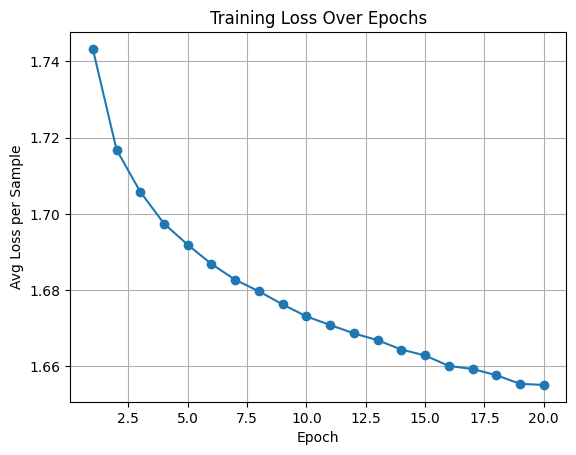

In [11]:
# 这段代码用于可视化模型训练过程中的损失变化
# 通过绘制损失曲线，我们可以：
# 1. 观察模型是否正常收敛
# 2. 判断是否需要调整学习率或训练轮数
# 3. 评估模型的训练效果

# 绘制训练损失曲线
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')  # 使用圆点标记每个数据点
plt.title('Training Loss Over Epochs')  # 设置图表标题
plt.xlabel('Epoch')  # 设置x轴标签
plt.ylabel('Avg Loss per Sample')  # 设置y轴标签
plt.grid(True)  # 显示网格线，便于读取数值
plt.show()  # 显示图表

## 🔮 7. 姓名补全预测函数 + 测试

In [9]:
# 这段代码实现了一个基于LSTM模型的姓名补全功能
# 主要功能：
# 1. 接收用户输入的名字前缀
# 2. 使用训练好的LSTM模型预测后续字符
# 3. 当遇到特定结束字符或达到最大长度时停止生成
# 4. 返回完整的生成名字

def predict_name(prefix, max_len=20):
    model.eval()  # 将模型设置为评估模式
    prefix = prefix.lower()  # 将输入前缀转换为小写
    generated = prefix  # 初始化生成的名字
    # 将输入前缀中的每个字符转换为对应的索引
    input_seq = [char_to_idx.get(ch, 0) for ch in prefix]

    # 循环生成后续字符，直到达到最大长度
    for _ in range(max_len - len(prefix)):
        # 创建输入张量，初始化为全0
        x = torch.zeros((1, max_seq_len), dtype=torch.long).to(device)
        # 将输入序列填充到张量中，从右侧开始填充
        x[0, -len(input_seq):] = torch.tensor(input_seq[-max_seq_len:], dtype=torch.long).to(device)

        # 使用模型进行预测
        with torch.no_grad():  # 不计算梯度
            output = model(x)  # 获取模型输出
            probs = torch.softmax(output, dim=1).squeeze()  # 将输出转换为概率分布
            next_char_idx = torch.argmax(probs).item()  # 选择概率最高的字符索引

        # 将预测的字符添加到生成的名字中
        next_char = idx_to_char[next_char_idx]
        generated += next_char
        input_seq.append(next_char_idx)

        # 如果遇到特定结束字符且名字长度大于4，则停止生成
        if next_char in ['n', 'y', 'e'] and len(generated) > 4:
            break
    return generated

# 测试不同前缀的补全效果
test_prefixes = ['j', 'a', 'mi', 'li', 'el', 'ch']
for prefix in test_prefixes:
    print(f"{prefix} ➜ {predict_name(prefix)}")

j ➜ jamariahan
a ➜ anataliahan
mi ➜ millian
li ➜ lilly
el ➜ elizabe
ch ➜ charlissan
